<a href="https://colab.research.google.com/github/John-D-Boom/CompVision/blob/main/Adding__Virtual_Nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title [RUN] Sanity check torch version and GPU runtime
import os
import torch
assert torch.cuda.is_available(), "WARNING! You are running on a non-GPU instance. For this practical a GPU is highly recommended."
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print('Installing scatter')
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    print('Installing sparse')
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # print('Installing cluster')
    # !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    print('Installing pytorch geometric')
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    print('Installing rdkit')
    !pip install -q rdkit-pypi==2021.9.4
    print('Installing py3Dmol')
    !pip install -q py3Dmol==1.8.0
else:
    print('already installed. Not repeating')
    print('To uninstall: !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y')



Installing scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.3 MB/s eta 0:00:00
Installing sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.7 MB/s eta 0:00:00
Installing pytorch geometric
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Installing rdkit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 24.1 MB/s eta 0:00:00
Installing py3Dmol


In [2]:
#@title [RUN] Import python modules

import os
import sys
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import files
from IPython.display import HTML

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch version 2.0.0+cu118
PyG version 2.4.0


In [3]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [4]:
#@title [RUN] Helper functions for data preparation

class SetTarget:
    """
    This transform modifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target  
        data.y = data.y[:, target]
        return data


class CompleteGraph:
    """
    This transform adds all pairwise edges into the edge index per data sample, 
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

print("Helper functions loaded.")

Helper functions loaded.


In [5]:
#@title [RUN] Helper functions for visualization

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

print("Helper functions added.")

Helper functions added.


In [6]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    # transform = T.Compose([CompleteGraph(), SetTarget()])
    transform = T.Compose([SetTarget()]) #Removed SetTarget to stop having them be fully connected
    
    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

Extracting qm9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:16<00:00, 679.97it/s]
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# print(f"Total number of samples: {len(dataset)}.")

# # Split datasets (in case of using the full dataset)
# # test_dataset = dataset[:10000]
# # val_dataset = dataset[10000:20000]
# # train_dataset = dataset[20000:]

# # Split datasets (our 3K subset)
# train_dataset = dataset[:1000]
# val_dataset = dataset[1000:2000]
# test_dataset = dataset[2000:3000]
# print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# # Create dataloaders with batch size = 32
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

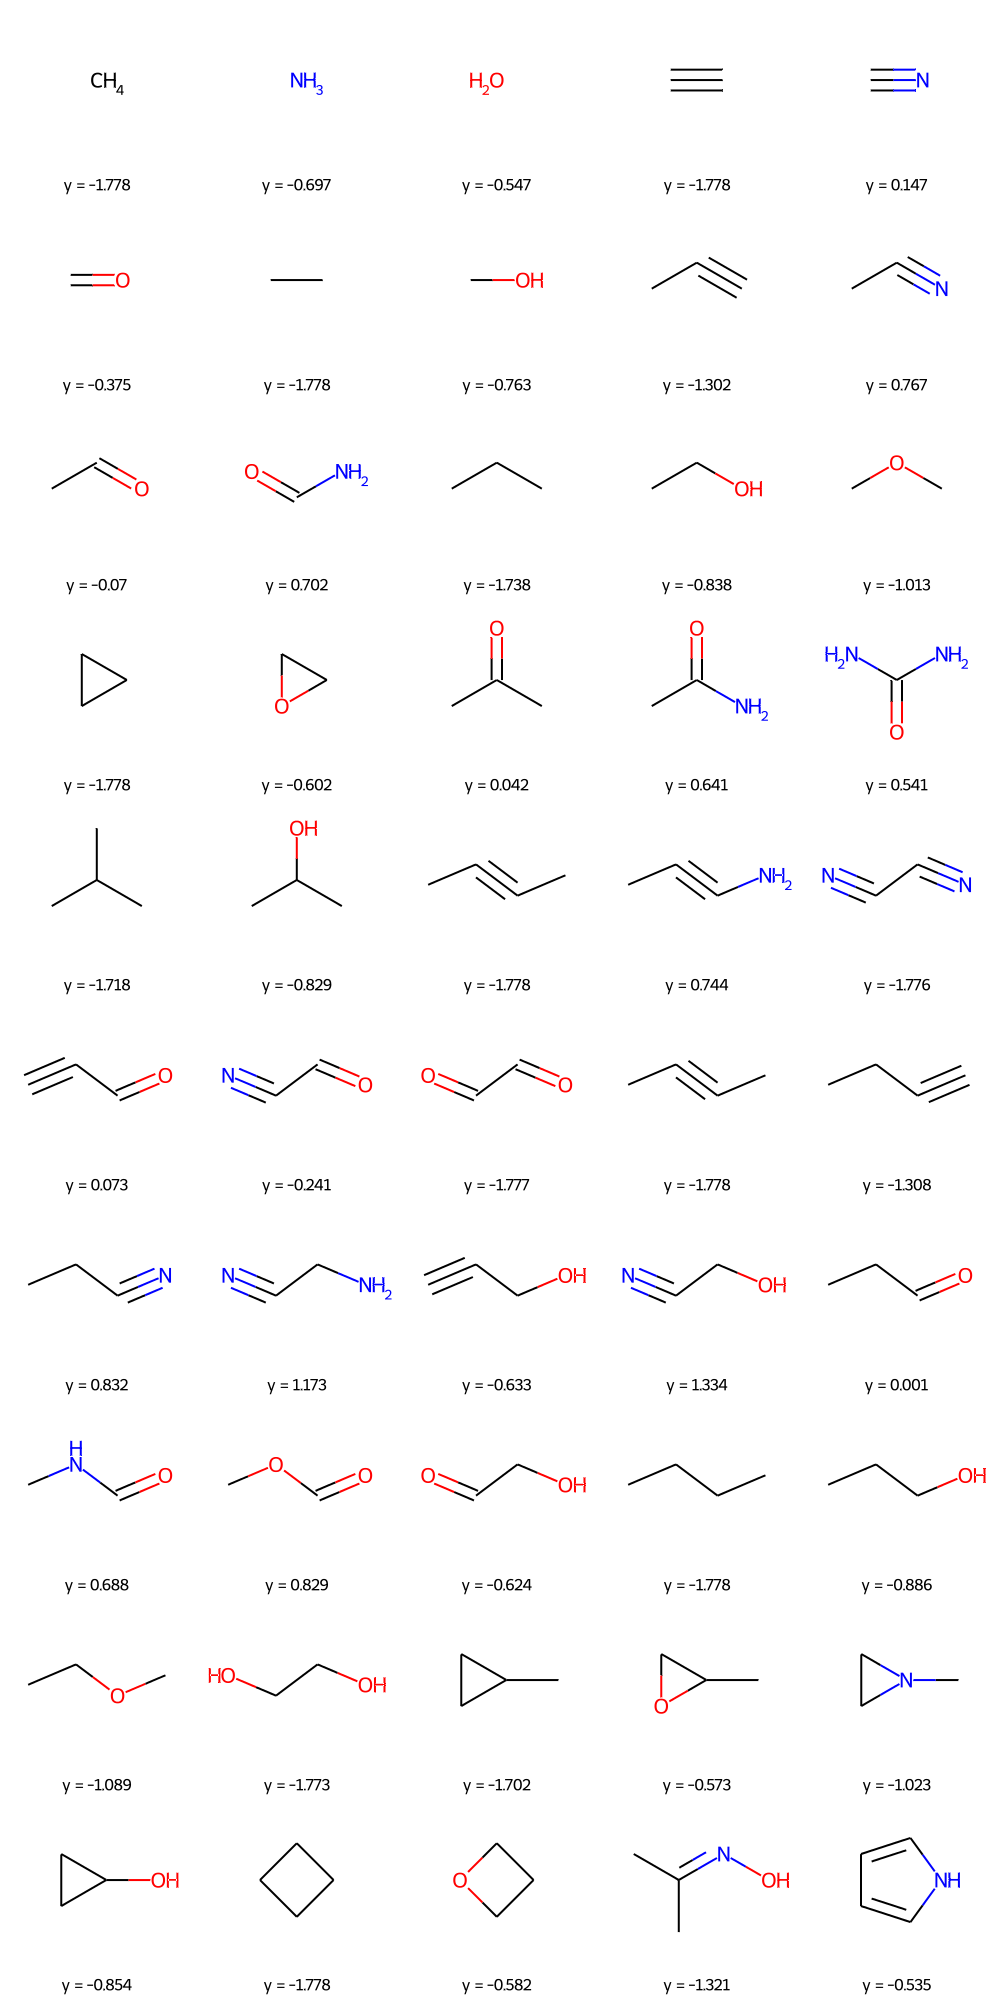

In [22]:
num_viz = 50
mols = [to_rdkit(dataset[i]) for i in range(num_viz)]
values = [str(round(float(dataset[i].y), 3)) for i in range(num_viz)]
Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

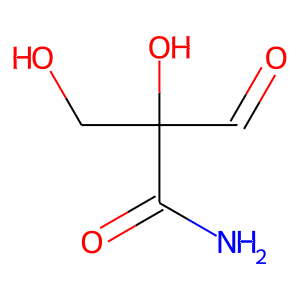

In [26]:
data = (dataset[98234])
Chem.Draw.MolToImage(to_rdkit(data))

# Custom Fxn to Plot original data objects in 3D manually

In [27]:
import plotly.graph_objects as go
from torch_geometric.utils.convert import to_networkx
import networkx as nx
def plot_molecule_3d(molecule):
    G = to_networkx(molecule)
    pos = nx.spring_layout(G, dim=3)
    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
    node_x = []
    node_y = []
    node_z = []
    node_color = []

    for node in G.nodes():
        x, y, z = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)

        # Use the first 5 features of the x tensor as a one-hot encoding of the atom identity
        atom_identity = torch.argmax(molecule.x[node][:5]).item()
        # Map the atom identity to a color
        if atom_identity == 0:
            color = 'white' # H
        elif atom_identity == 1:
            color = 'black' # C
        elif atom_identity == 2:
            color = 'blue' # N
        elif atom_identity == 3:
            color = 'red' # O
        elif atom_identity == 4:
            color = 'purple' # F
        else:
            color = 'green' # Virtual Node
        node_color.append(color)
    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers', 
                                marker=dict(size=8, color=node_color))
    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', 
                                line=dict(color='black', width=1), hoverinfo='none')
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                    yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                    zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False)),
        showlegend=False))
    fig.show()

In [28]:
plot_molecule_3d(data)

In [14]:
def add_virtual_one_hot(tensor):
    # Get the shape of the input tensor
    n, m = tensor.shape
    assert m == 11, "input tensor should have 11 features, just like atom3d dataset. found {}".format(m)
    new_tensor = torch.zeros((n, 12))
    new_tensor[:, :5] = tensor[:, :5]
    new_tensor[:, 6:] = tensor[:, 5:]
    return new_tensor

In [75]:
import torch

# Create an example tensor
tensor = torch.rand((10, 12))
tensor[:, 5] = torch.randint(0, 2, (10,))  # Set random values for the 6th column

# Get the indices of all rows where the 6th element is 1
indices = torch.nonzero(tensor[:, 5] == 1, as_tuple=False)

print(f"Indices of rows where the 6th element is 1:\n{indices}")
for idx in indices:
    print(int(idx[0]))

Indices of rows where the 6th element is 1:
tensor([[0],
        [6],
        [7],
        [8],
        [9]])
0
6
7
8
9


# Adding Virtual node to geometric.data.Data object. 
Connects to nodes from list nodes_to_connect

In [76]:
import copy
def add_virtual_node(graph_in: torch_geometric.data.Data, nodes_to_connect: list):


    graph = copy.copy(graph_in)
    #Node will be appended to the end of the array
    virtual_index = len(graph.x) 

    #Pad the features with an extra one hot column in the 6th position to 
    #indicate the virtual node
    #Only do this if no virtual nodes have been added before
    if graph.x.shape[1] == 11:
        graph.x = add_virtual_one_hot(graph.x)

    #Add node to x features
    new_node_x = torch.zeros((1,12))
    new_node_x[0,5] = 1
    graph.x = torch.cat([graph.x, new_node_x], dim=0)
    assert graph.x.shape[0] == virtual_index + 1, print(graph.x.shape)

    #Add edges connecting the node to nodes_to_connect
    new_edges = [[], []]
    for node in nodes_to_connect:
        assert node >= 0
        assert node < len(graph.x-1) #node must have been possible in orig graph

        #Add edge in both directions
        new_edges[0].append(virtual_index)
        new_edges[1].append(node)

        new_edges[0].append(node)
        new_edges[1].append(virtual_index)

    #Add edges connecting the virtual node to all other virtual nodes
    # 1. get list of the nodes with virtual_node identifier
    # 2. Fully connect it

    virtual_indices = torch.nonzero(graph.x[:-1, 5] == 1, as_tuple=False) #:-1 to not include itself
    for idx in virtual_indices:
        assert node >= 0
        assert node < len(graph.x-1)
        assert node != virtual_index
        node = int(idx[0])
        new_edges[0].append(virtual_index)
        new_edges[1].append(node)

        new_edges[0].append(node)
        new_edges[1].append(virtual_index)

    graph.edge_index = torch.cat([graph.edge_index, torch.tensor(new_edges)], dim = 1)


    #Add a position to node based on arithmetic mean of positions
    virtual_pos = torch.zeros((1,3))
    for node in nodes_to_connect:
        assert node >= 0
        assert node < len(graph.x-1) #node must have been possible in orig graph
        virtual_pos = virtual_pos + graph.pos[node]
    virtual_pos = virtual_pos / (virtual_index-1)
    graph.pos = torch.cat([graph.pos, virtual_pos])
    
    #update z just cuz
    graph.z = torch.cat([graph.z, torch.tensor([0])])

    #update edge_attributes to be "single" bonds. Currently my MPNN won't 
    #analyze the actual bonds so it doesn't matter. However, this might help it 
    #plot and will ensure consistency
    new_edge_attr = torch.zeros((len(new_edges[0])), 4)
    new_edge_attr[:, 0] = 1
    graph.edge_attr = torch.cat([graph.edge_attr, new_edge_attr], dim = 0)
        
    return graph

In [77]:
data = dataset[98234]
temp_data = add_virtual_node(data, [0,1,2])
temp_data

Data(x=[17, 12], edge_index=[2, 36], edge_attr=[36, 4], y=[1], pos=[17, 3], z=[17], name='gdb_100178', idx=[1])

In [78]:
def plot_virtual_molecule_3d(molecule):

    #Function that can handle the virtual node
    G = to_networkx(molecule)
    pos = nx.spring_layout(G, dim=3)
    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
    node_x = []
    node_y = []
    node_z = []
    node_color = []

    for node in G.nodes():
        x, y, z = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)

        # Use the first 6 features of the x tensor as a one-hot encoding of the atom identity
        atom_identity = torch.argmax(molecule.x[node][:6]).item()
        # Map the atom identity to a color
        if atom_identity == 0:
            color = 'white' # H
        elif atom_identity == 1:
            color = 'black' # C
        elif atom_identity == 2:
            color = 'blue' # N
        elif atom_identity == 3:
            color = 'red' # O
        elif atom_identity == 4:
            color = 'purple' # F
        else:
            color = 'green' # Virtual Node
        node_color.append(color)
    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers', 
                                marker=dict(size=8, color=node_color))
    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', 
                                line=dict(color='black', width=1), hoverinfo='none')
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                    yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False),
                    zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False)),
        showlegend=False))
    fig.show()

In [79]:
plot_virtual_molecule_3d(temp_data)

Alright. I'm not including double bonds or anything in my plotting, but I can clearly see that my new virtual node (green) is hooked up exactly like I wanted!

# Incorportating Clustering

## METIS ALGORITHM

### Using ClusterData from torch_geometric.data


In [46]:
from torch_geometric.data import ClusterData
data = dataset[98234]
num_clusters = 2

# Use ClusterData to preprocess the dataset
cluster_data = ClusterData(
    data, 
    num_parts=4, 
    recursive=False,
    log=True,
)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning:

'data.ClusterData' is deprecated, use 'loader.ClusterData' instead

Computing METIS partitioning...
Done!


In [68]:
def get_clusters(data:torch_geometric.data.Data, num_clusters: int):

    cluster_data = ClusterData(data, num_parts=num_clusters, recursive=False, log=True)
    
    clusters = {} #key: cluster_number | value: list of nodes in that cluster
    for i, cluster in enumerate(cluster_data):
        clusters[i] = []
        for node_pos in cluster.pos:
            node_index = int(torch.nonzero(torch.eq(node_pos, data.pos).all(dim=1))[0][0])
            clusters[i].append(node_index)

    return clusters

In [82]:
data = dataset[98234]
new_data = data
clusters = get_clusters(data, 4)
for node_list in clusters.values():
    new_data = add_virtual_node(new_data, node_list)

plot_virtual_molecule_3d(new_data)


Computing METIS partitioning...
Done!
